# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
#from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [5]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [6]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 1636/1636 [08:46<00:00,  3.11it/s]


In [7]:
dataframes[30]

('data/all_nano_structures_single_domain/6rbb.pdb',
              X          Y       Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     0.694000  -4.277000   5.308  174.20274           3.721274   
 1    -2.990000  -4.576000   5.740   75.06714           4.198928   
 2    -6.508000  -3.784000   4.701  105.09344           3.805953   
 3    -8.875000  -3.795000   7.749  147.13074           3.833386   
 4    -6.175000  -5.348000   9.939  165.19184           3.788165   
 ..         ...        ...     ...        ...                ...   
 478 -33.832001 -20.900999  10.996  117.14784           4.169421   
 479 -33.150002 -18.483999   8.138  119.12034           4.082392   
 480 -34.498001 -14.935000   8.444  117.14784           4.093996   
 481 -34.692001 -12.858000   5.268  105.09344           4.145524   
 482 -34.766998  -9.058000   5.304  105.09344           3.800911   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3.721274               1                      1  


In [8]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [9]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    # Optionally include coordinates in node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):  # Skip self-loop (j=0)
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )
    return data


In [10]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1636 [00:00<?]

# Graph representation vs reality

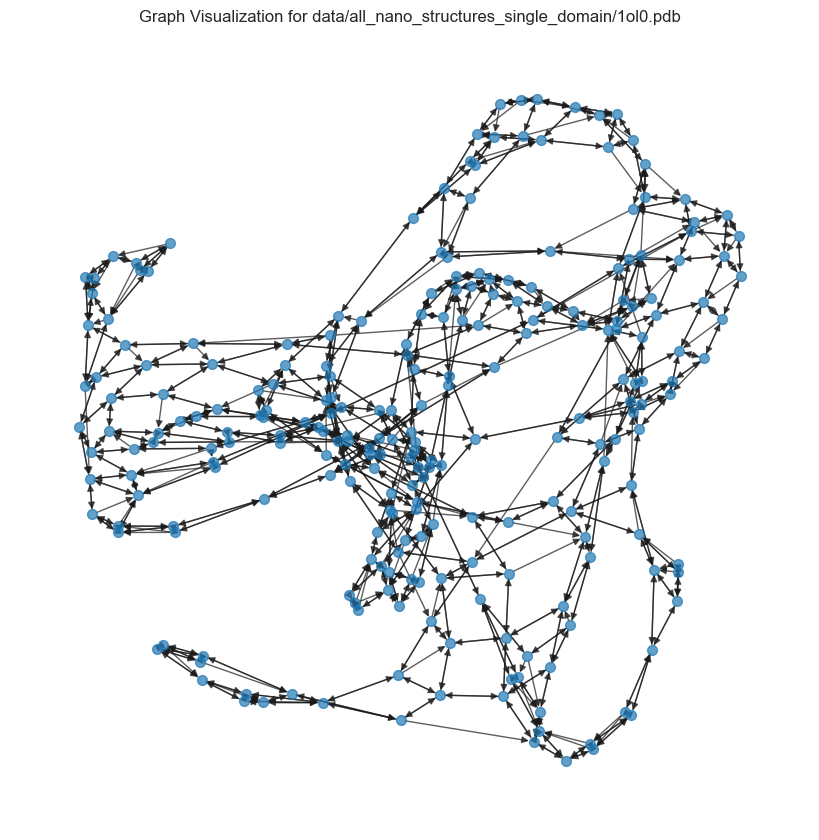

In [11]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph(data, pdb_file)


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Define amino acid masses and their corresponding colors
AMINO_ACID_DATA = [
    (89.09404, "Alanine", "blue"),
    (121.15404, "Cysteine", "green"),
    (133.10384, "Aspartic acid", "red"),
    (147.13074, "Glutamic acid", "cyan"),
    (165.19184, "Phenylalanine", "magenta"),
    (75.06714, "Glycine", "yellow"),
    (155.15634, "Histidine", "orange"),
    (131.17464, "Isoleucine/Leucine", "purple"),
    (146.18934, "Lysine", "brown"),
    (149.20784, "Methionine", "pink"),
    (132.11904, "Asparagine", "lime"),
    (255.31000, "Pyrrolysine", "gold"),
    (115.13194, "Proline", "silver"),
    (146.14594, "Glutamine", "teal"),
    (174.20274, "Arginine", "coral"),
    (105.09344, "Serine", "navy"),
    (119.12034, "Threonine", "olive"),
    (168.05300, "Selenocysteine", "maroon"),
    (117.14784, "Valine", "black"),
    (204.22844, "Tryptophan", "violet"),
    (181.19124, "Tyrosine", "gray"),
]

# Convert amino acid data to lookup tables
MASS_TO_COLOR = {mass: color for mass, _, color in AMINO_ACID_DATA}
MASS_TO_NAME = {mass: name for mass, name, _ in AMINO_ACID_DATA}

def map_mass_to_color(mass):
    """Find the closest amino acid mass and return its color."""
    closest_mass = min(MASS_TO_COLOR.keys(), key=lambda m: abs(m - mass))
    return MASS_TO_COLOR[closest_mass]

def visualize_nanobody_graph_aminoacids(data, pdb_file):
    """
    Visualize a nanobody graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object.
    - pdb_file: Name of the nanobody structure file.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
        map_mass_to_color(node[1]['x'][0]) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [max(10, node[1]['x'][3] * 50) for node in G.nodes(data=True)]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [max(0.1, edge[2]['edge_attr'][0]) for edge in G.edges(data=True)]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(f"Graph Visualization for {pdb_file}", fontsize=14)
    plt.show()


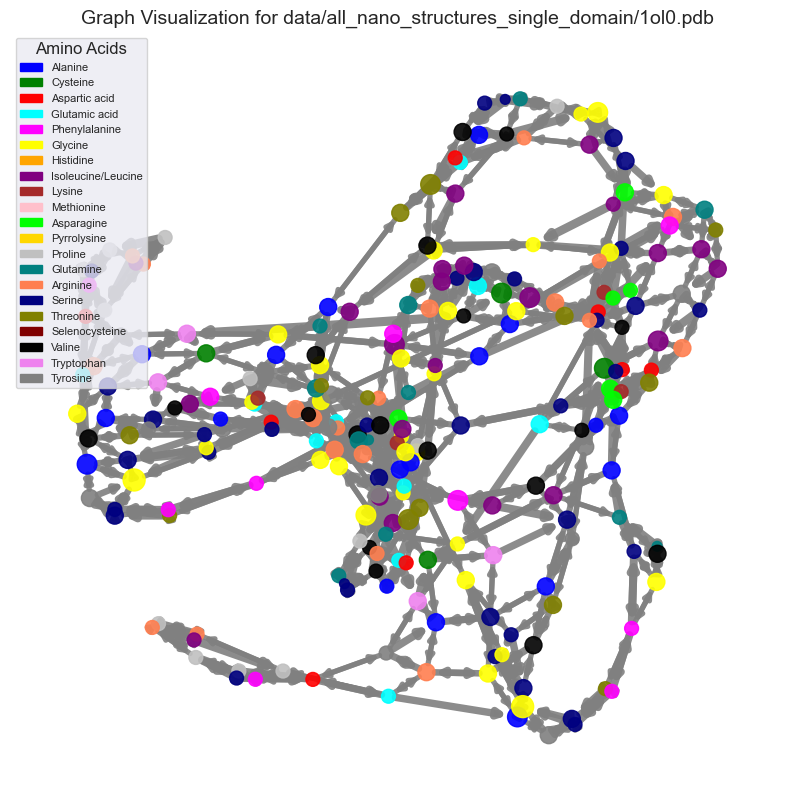

In [13]:
# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph_aminoacids(data, pdb_file)

In [14]:
# from IPython.display import display
# from PIL import Image
# import matplotlib.pyplot as plt

# # Paths to your images
# image_path_1 = "data/mab_dataset/3sn6.png"
# image_path_2 = "data/mab_dataset/3sn6_plot.png"

# # Open the images using PIL
# image_1 = Image.open(image_path_1)
# image_2 = Image.open(image_path_2)

# # Create a matplotlib figure
# fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

# # Display the first image
# axes[0].imshow(image_1)
# axes[0].axis('off')  # Hide axes
# axes[0].set_title("Image 1: Original")

# # Display the second image
# axes[1].imshow(image_2)
# axes[1].axis('off')  # Hide axes
# axes[1].set_title("Image 2: Plot")

# # Show the images
# plt.tight_layout()
# plt.show()


# Dataloader

In [15]:
# from torch_geometric.loader import DataLoader
# from sklearn.model_selection import train_test_split

# def split_and_batch_graphs(graphs, batch_size=8, train_ratio=0.8, seed=42):
#     """
#     Split the graphs into train and test datasets, and create DataLoaders for batching.

#     Parameters:
#     - graphs (list): List of `torch_geometric.data.Data` graphs.
#     - batch_size (int): Batch size for the DataLoader.
#     - train_ratio (float): Proportion of data to use for training.
#     - seed (int): Random seed for reproducibility.

#     Returns:
#     - train_loader (DataLoader): DataLoader for the training set.
#     - test_loader (DataLoader): DataLoader for the testing set.
#     """
#     # Set random seed for reproducibility
#     torch.manual_seed(seed)
    
#     # Split into train and test sets
#     train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
#     # Create DataLoaders
#     train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
#     return train_loader, test_loader


In [16]:
# # Unpack graphs
# graph_data = [graph for _, graph in graphs]  # Extract only the `Data` objects

# # Split and batch the graphs
# train_loader, test_loader = split_and_batch_graphs(graph_data, batch_size=16, train_ratio=0.8, seed=42)

# # Optional: Keep file names for reference
# pdb_files = [pdb_file for pdb_file, _ in graphs]

# # Example: Iterate through training batches
# for batch in train_loader:
#     print(batch)  # This should now work as expected


# GTA VAE Alex V10

In [61]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)
    feature_means = all_features.mean(dim=0)
    feature_stds = all_features.std(dim=0)

    # Prevent division by zero
    feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)

    # Normalize all graphs
    for graph in graphs:
        graph.x = (graph.x - feature_means) / feature_stds

        # Also normalize edge attributes (distances)
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = graph.edge_attr.std()
            if edge_std > 0:
                graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Rest of your existing function...
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Feature means:", feature_means)
    print(f"Feature stds:", feature_stds)

    # Return normalization parameters for later use (e.g., inference)
    return train_loader, test_loader, in_channels, (feature_means, feature_stds)

def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)

In [62]:
class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=32, num_heads=4, edge_dim=1):
        super(ProteinGraphVAE, self).__init__()

        # Model parameters
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.latent_channels = latent_channels
        self.edge_dim = edge_dim

        # Feature indices
        self.coord_indices = slice(-3, None)
        self.mass_index = 0
        self.distance_indices = slice(1, 3)
        self.count_index = 3
        self.small_mol_index = 4

        # Loss weights
        # Update these weights in the __init__ method
        self.loss_weights = {
            'mass': 0.1,       # Reduced to prevent domination
            'distance': 0.1,   # Reduced for better balance
            'count': 0.1,      # Reduced for better balance
            'small_mol': 0.1,  # Reduced to prevent instability
            'coord': 0.1,      # Kept small for coordinates
            'edge': 0.1        # Reduced for balance
        }

        # Encoder
        self.encoder_conv1 = torch.nn.ModuleList([
            GATConv(
                in_channels,
                hidden_channels,
                heads=num_heads,
                edge_dim=edge_dim,
                concat=True
            )
        ])

        self.encoder_conv2 = torch.nn.ModuleList([
            GATConv(
                hidden_channels * num_heads,
                hidden_channels,
                edge_dim=edge_dim,
                concat=False
            )
        ])

        # Encoder feedforward
        self.encoder_ff = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_channels, latent_channels)
        self.fc_logvar = nn.Linear(hidden_channels, latent_channels)

        # Decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Feature-specific heads
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3),
            nn.Tanh()  # Constrain coordinates
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()  # Ensure positive mass
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2),
            nn.Softplus()  # Ensure positive distances
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()  # Ensure positive count
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)  # No activation - using BCEWithLogitsLoss
        )

        # Edge decoder
        self.edge_decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, edge_dim),
            nn.Softplus()  # Ensure positive edge attributes
        )

    def encode(self, x, edge_index, edge_attr, batch):
        # Graph convolutions
        for conv in self.encoder_conv1:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        for conv in self.encoder_conv2:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        # Additional feature processing
        x = self.encoder_ff(x)

        # Pool and get latent parameters
        x = global_mean_pool(x, batch)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, num_nodes, edge_index):
        batch_size = z.size(0)

        # Add position-specific noise
        z = z.unsqueeze(1).expand(-1, num_nodes, -1)
        position_noise = torch.randn_like(z) * 0.05  # Reduced noise
        z = z + position_noise
        z = z.reshape(-1, self.latent_channels)

        # Decode features
        h = self.shared_decoder(z)

        # Decode node features with specific activations
        coords = self.coord_head(h) * 10  # Scale coordinates
        mass = self.mass_head(h)
        distances = self.distance_head(h)
        counts = self.count_head(h)
        small_mols = self.small_mol_head(h)

        # Decode edge attributes
        row, col = edge_index
        edge_features = torch.cat([h[row], h[col]], dim=1)
        decoded_edges = self.edge_decoder(edge_features)

        # Combine features
        features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)
        return features.view(batch_size, num_nodes, -1), decoded_edges

    def feature_specific_loss(self, recon, target, edge_recon, edge_target):
        losses = {}
        EPS = 1e-6
    
        # Mass loss - using softplus for positive values
        mass_pred = F.softplus(recon[..., self.mass_index])  # Remove clamp
        mass_target = target[..., self.mass_index]
        # Use mean instead of max for more stable scaling
        mass_scale = mass_target.abs().mean() + EPS
        mass_pred_scaled = mass_pred / mass_scale
        mass_target_scaled = mass_target / mass_scale
        losses['mass'] = F.mse_loss(mass_pred_scaled, mass_target_scaled) * self.loss_weights['mass']
    
        # Distance loss
        dist_pred = F.softplus(recon[..., self.distance_indices])  # Remove clamp
        dist_target = target[..., self.distance_indices]
        dist_scale = dist_target.abs().mean() + EPS
        dist_pred_scaled = dist_pred / dist_scale
        dist_target_scaled = dist_target / dist_scale
        losses['distance'] = F.mse_loss(dist_pred_scaled, dist_target_scaled) * self.loss_weights['distance']
    
        # Count loss
        count_pred = F.softplus(recon[..., self.count_index])  # Remove clamp
        count_target = target[..., self.count_index]
        count_scale = count_target.abs().mean() + EPS
        count_pred_scaled = count_pred / count_scale
        count_target_scaled = count_target / count_scale
        losses['count'] = F.mse_loss(count_pred_scaled, count_target_scaled) * self.loss_weights['count']
    
        # Small molecules loss - binary cross entropy
        small_mol_pred = recon[..., self.small_mol_index]  # Remove clamp
        small_mol_target = target[..., self.small_mol_index].clamp(0, 1)  # Keep target binary
        losses['small_mol'] = F.binary_cross_entropy_with_logits(
            small_mol_pred,
            small_mol_target,
            reduction='mean'
        ) * self.loss_weights['small_mol']
    
        # Coordinate loss - no activation needed
        coord_pred = recon[..., self.coord_indices]
        coord_target = target[..., self.coord_indices]
        coord_scale = coord_target.abs().mean() + EPS
        coord_pred_scaled = coord_pred / coord_scale
        coord_target_scaled = coord_target / coord_scale
        losses['coord'] = F.mse_loss(coord_pred_scaled, coord_target_scaled) * self.loss_weights['coord']
    
        # Edge loss
        edge_pred = F.softplus(edge_recon)  # Remove clamp
        edge_target_pos = F.softplus(edge_target)
        edge_scale = edge_target_pos.abs().mean() + EPS
        edge_pred_scaled = edge_pred / edge_scale
        edge_target_scaled = edge_target_pos / edge_scale
        losses['edge'] = F.mse_loss(edge_pred_scaled, edge_target_scaled) * self.loss_weights['edge']
    
        # Calculate total loss without clamping
        total_loss = sum(loss for loss in losses.values() if torch.isfinite(loss))
    
        return total_loss, losses

    def forward(self, x, edge_index, edge_attr, batch):
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        unique, counts = torch.unique(batch, return_counts=True)
        max_nodes = counts.max().item()

        recon, edge_recon = self.decode(z, max_nodes, edge_index)
        return recon, edge_recon, mu, logvar

In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def kl_annealing_factor(epoch, warmup_epochs=10, min_weight=0.0001, max_weight=1.0):
    """Compute KL annealing factor that gradually increases from min_weight to max_weight"""
    if epoch < warmup_epochs:
        return min_weight + (max_weight - min_weight) * (epoch / warmup_epochs)
    return max_weight

def compute_orthogonal_regularization(mu, lambda_ortho=0.1):
    """Compute orthogonality regularization for the latent space"""
    batch_size = mu.size(0)
    mu_normalized = F.normalize(mu, p=2, dim=1)  # Normalize each embedding
    correlation = torch.mm(mu_normalized.t(), mu_normalized) / batch_size
    identity = torch.eye(correlation.size(0), device=correlation.device)
    ortho_loss = lambda_ortho * torch.sum((correlation - identity) ** 2)
    return ortho_loss

def train_model(model, train_loader, test_loader, device, num_epochs=100,
                min_beta=0.0001, max_beta=0.01, warmup_epochs=10, lambda_ortho=0.1):
    """
    Train VAE model with KL annealing and orthogonal regularization
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 1.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")
    print(f"KL annealing: {min_beta} -> {max_beta} over {warmup_epochs} epochs")
    print(f"Orthogonal regularization strength: {lambda_ortho}")

    history = {
        'train': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': [],
            'beta': []  # Track KL weight
        },
        'test': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []
        }
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Get current KL weight from annealing schedule
        current_beta = kl_annealing_factor(epoch, warmup_epochs, min_beta, max_beta)
        epoch_losses['beta'] = current_beta

        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                # Calculate losses
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Add orthogonality regularization
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)

                # Combine losses with annealed KL weight
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 10 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"Ortho loss: {ortho_loss.item():.4f}")
                        print(f"Current beta: {current_beta:.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update progress bar and losses
                batch_count += 1
                epoch_losses['total_loss'] += loss.item()
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                epoch_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                # Update progress bar description
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}',
                    'ortho': f'{ortho_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average losses
        num_batches = len(train_loader)
        for k in epoch_losses:
            if k != 'beta':  # Don't average the beta value
                epoch_losses[k] = epoch_losses[k] / num_batches
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                batch = batch.to(device)
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                test_losses['total_loss'] += loss.item()
                test_losses['recon_loss'] += recon_loss.item()
                test_losses['kl_loss'] += kl_loss.item()
                test_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    test_losses[f'{k}_loss'] += v.item()

        # Average test losses
        for k in test_losses:
            test_losses[k] /= len(test_loader)
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train - Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}, '
              f'Ortho: {epoch_losses["ortho_loss"]:.4f}, '
              f'Beta: {current_beta:.4f}')
        print('Feature Losses:')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0:  # Plot every epoch
            plt.figure(figsize=(20, 10))

            # Plot 1: Total, Reconstruction, KL, and Ortho losses
            plt.subplot(2, 2, 1)
            plt.plot(history['train']['total_loss'], label='Total Loss')
            plt.plot(history['train']['recon_loss'], label='Reconstruction Loss')
            plt.plot(history['train']['kl_loss'], label='KL Loss')
            plt.plot(history['train']['ortho_loss'], label='Ortho Loss')
            plt.plot(history['train']['beta'], label='Beta (KL weight)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Losses')
            plt.legend()
            plt.grid(True)

            # Plot 2: Feature-specific losses
            plt.subplot(2, 2, 2)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                plt.plot(history['train'][k], label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Feature-specific Losses')
            plt.legend()
            plt.grid(True)

            # Plot 3: Feature-specific losses (log scale)
            plt.subplot(2, 2, 3)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                values = [max(1e-10, abs(x)) for x in history['train'][k]]
                plt.semilogy(values, label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss (log scale)')
            plt.title('Feature-specific Losses (Log Scale)')
            plt.legend()
            plt.grid(True)

            # Plot 4: Training vs Validation losses
            plt.subplot(2, 2, 4)
            plt.plot(history['train']['total_loss'], label='Train Loss')
            plt.plot(history['test']['total_loss'], label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training vs Validation Loss')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    print("\nTraining completed!")
    return model, history

In [64]:
# First, instantiate the model
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=32,
    num_heads=4,
    edge_dim=1
)

# Print model structure and parameter count
print("Model structure:")
print(model)

print("\nParameter count by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")
        total_params += param.numel()
print(f"\nTotal trainable parameters: {total_params}")

Model structure:
ProteinGraphVAE(
  (encoder_conv1): ModuleList(
    (0): GATConv(8, 64, heads=4)
  )
  (encoder_conv2): ModuleList(
    (0): GATConv(256, 64, heads=1)
  )
  (encoder_ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_mu): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  (shared_decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (coord_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True

In [65]:
device=get_device()

INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility


In [66]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def plot_latent_space(model, data_loader, device, method='pca'):
    """
    Plot the latent space of the model using PCA or t-SNE.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
        method: Dimensionality reduction method ('pca' or 'tsne').

    Returns:
        None
    """
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(batch.batch.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_latent = reducer.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=labels[:reduced_latent.shape[0]], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Batch')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [67]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

Dataset prepared:
Number of training graphs: 1308
Number of test graphs: 328
Number of features per node: 8
Feature means: tensor([-5.3501e-09, -4.5757e-10,  3.6606e-09,  1.3305e-08, -1.6788e-08,
         8.3837e-09,  9.4716e-09,  8.8149e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


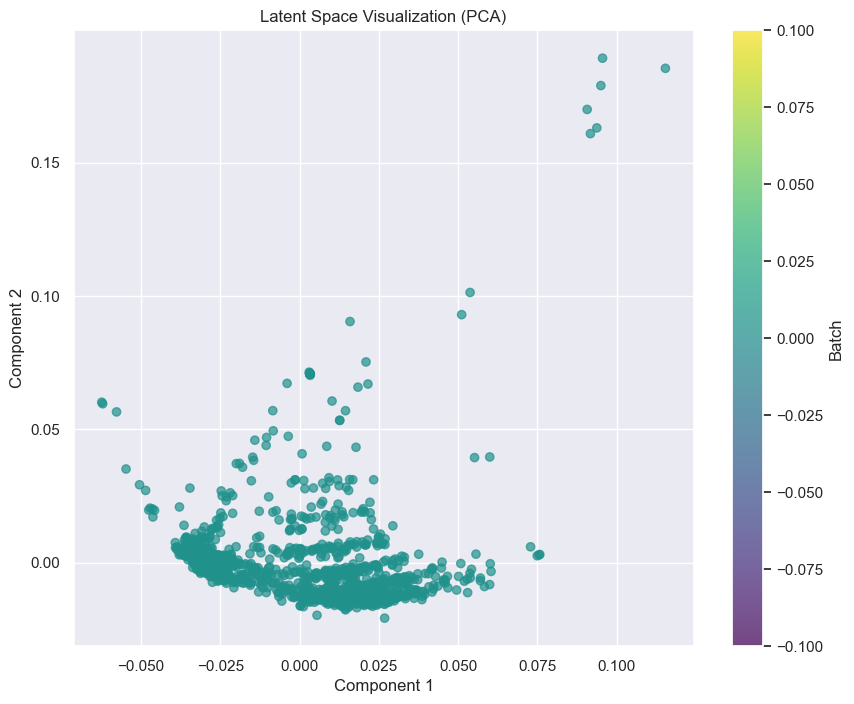

In [68]:
# Assuming `train_loader` is your DataLoader and `model` is your ProteinGraphVAE instance
plot_latent_space(model, train_loader, device, method='pca')

In [69]:
def sample_and_decode(model, num_samples=5, device='cpu'):
    """
    Sample random latent vectors and decode them to check for diversity in outputs.

    Args:
        model: Trained ProteinGraphVAE model.
        num_samples: Number of samples to generate.
        device: torch device.

    Returns:
        List of decoded node features.
    """
    model.eval()
    decoded_samples = []

    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, model.latent_channels, device=device)
            node_counts = torch.tensor([500], device=device)  # Adjust node count as needed
            edge_index = torch.zeros((2, 0), dtype=torch.long, device=device)  # Dummy edge_index
            node_features, edge_attr = model.decode(z, node_counts, edge_index)
            decoded_samples.append(node_features.cpu().numpy())

    return decoded_samples

# Example usage
decoded_samples = sample_and_decode(model, num_samples=5, device=device)
for i, sample in enumerate(decoded_samples):
    print(f"Sample {i+1}:")
    print(sample)

Sample 1:
[[[ 0.7099047   0.6258684   0.64952344 ... -1.2352978   0.40208548
    0.73991454]
  [ 0.7103822   0.6256637   0.6494836  ... -1.2181377   0.39900276
    0.74014556]
  [ 0.71047497  0.62560934  0.6496902  ... -1.21929     0.39137754
    0.7562641 ]
  ...
  [ 0.7112562   0.6256747   0.6493475  ... -1.1821619   0.39184636
    0.7672849 ]
  [ 0.7108593   0.62616843  0.6491138  ... -1.2094126   0.38179484
    0.77415043]
  [ 0.71033174  0.6264019   0.64934635 ... -1.214329    0.38153347
    0.76298213]]]
Sample 2:
[[[ 7.0039159e-01  6.2699604e-01  6.4849776e-01 ... -1.3032960e+00
    1.1725724e-03  9.6029139e-01]
  [ 6.9938987e-01  6.2686902e-01  6.4853567e-01 ... -1.3213522e+00
   -2.6922757e-02  9.6116126e-01]
  [ 6.9868165e-01  6.2817645e-01  6.4850450e-01 ... -1.3190012e+00
   -2.8368978e-02  9.6860319e-01]
  ...
  [ 6.9942492e-01  6.2731290e-01  6.4877492e-01 ... -1.2962459e+00
    1.1543627e-02  9.4056046e-01]
  [ 6.9938910e-01  6.2694865e-01  6.4854050e-01 ... -1.2880307e+

In [70]:
import torch
import torch.nn.functional as F


import torch

import torch

def generate_protein(model, n_nodes=500, device='cpu', feature_stats=None):
    """
    Generate a new protein structure from random latent vector

    Args:
        model: Trained ProteinGraphVAE model
        n_nodes: Number of nodes to generate
        device: torch device
        feature_stats: Tuple of (means, stds) used during training for normalization
    """
    model.eval()
    z = torch.randn(1, model.latent_channels, device=device)
    node_counts = torch.tensor([n_nodes], device=device)

    # Generate the edge index using a simple approach
    edge_probability = 0.1
    num_edges = int(n_nodes * (n_nodes - 1) * edge_probability / 2)
    row = torch.randint(0, n_nodes, (num_edges,), device=device)
    col = torch.randint(0, n_nodes, (num_edges,), device=device)
    edge_index = torch.stack([row, col], dim=0)

    with torch.no_grad():
        node_features, edge_attr = model.decode(z, node_counts, edge_index)

        # Denormalize if stats provided
        if feature_stats is not None:
            means, stds = feature_stats
            node_features = node_features * stds + means

    return node_features, edge_index, edge_attr

def plot_protein_structure(node_features, edge_index, title="Protein Structure"):
    coords = node_features[:, :3].cpu().numpy()
    edge_index_np = edge_index.cpu().numpy()

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=50, c='blue')

    # Plot edges
    edges_x = []
    edges_y = []
    edges_z = []
    for i in range(edge_index_np.shape[1]):
        start_idx = edge_index_np[0, i]
        end_idx = edge_index_np[1, i]

        # Check if the indices are within the range of the node_features tensor
        if start_idx < coords.shape[0] and end_idx < coords.shape[0]:
            edges_x.extend([coords[start_idx, 0], coords[end_idx, 0], None])
            edges_y.extend([coords[start_idx, 1], coords[end_idx, 1], None])
            edges_z.extend([coords[start_idx, 2], coords[end_idx, 2], None])

    ax.plot(edges_x, edges_y, edges_z, c='gray', linewidth=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.show()
    
def print_node_statistics(node_features):
    """
    Print statistics about the generated nodes
    """
    print("\nNode Feature Statistics:")
    print(f"Number of nodes: {node_features.shape[0]}")

    # Print statistics for each feature
    feature_names = ['Mass', 'Avg Neighbor Dist', 'Max Neighbor Dist',
                     'Neighbor Count', 'Small Molecules', 'X', 'Y', 'Z']

    for i, name in enumerate(feature_names):
        if i == 1:  # Distance features are 2D
            values = node_features[:, 1:3]
            mean = values.mean(dim=0)
            std = values.std(dim=0)
            print(f"\n{name}:")
            print(f"Mean: {mean.tolist()}")
            print(f"Std: {std.tolist()}")
        elif i < 5:  # Other scalar features
            values = node_features[:, i]
            print(f"\n{name}:")
            print(f"Mean: {values.mean():.3f}")
            print(f"Std: {values.std():.3f}")
            print(f"Min: {values.min():.3f}")
            print(f"Max: {values.max():.3f}")

    # Print coordinate statistics
    coords = node_features[:, 5:8]
    print("\nCoordinate Statistics:")
    print(f"Center of mass: {coords.mean(dim=0).tolist()}")
    print(f"Spatial extent: {coords.std(dim=0).tolist()}")

# Usage example:
def generate_and_visualize_protein(model, n_nodes=500, device='cpu'):
    """
    Generate and visualize a new protein structure
    """
    # Generate protein
    node_features, edge_index, edge_attr = generate_protein(model, n_nodes, device)

    # Print statistics
    print_node_statistics(node_features)

    # Plot structure
    plot_protein_structure(node_features, edge_index)

    return node_features, edge_index, edge_attr


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.319
Std: 0.697
Min: -1.320
Max: 0.725

Avg Neighbor Dist:
Mean: [[0.7051668167114258, 0.6428959369659424, 0.6676503419876099, 0.7259896397590637, 0.05621151626110077, -1.312523365020752, 0.4706065356731415, 0.5879698991775513], [0.7040855288505554, 0.6428930163383484, 0.668383777141571, 0.7253539562225342, 0.05588725954294205, -1.3156853914260864, 0.46717655658721924, 0.6009923815727234]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.319
Std: 0.695
Min: -1.316
Max: 0.725

Neighbor Count:
Mean: 0.319
Std: 0.690
Min: -1.301
Max: 0.726

Small Molecules:
Mean: 0.323
Std: 0.693
Min: -1.306
Max: 0.725

Coordinate Statistics:
Center of mass: [[0.704311728477478, 0.6410907506942749, 0.6693028211593628, 0.7258686423301697, 0.051886193454265594, -1.2928056716918945, 0.45805707573890686, 0.6152290105819702], [0.7050324082374573, 0.6424778699874878, 0.667894721031189,

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:87: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = values.std(dim=0)
/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  print(f"Spatial extent: {coords.std(dim=0).tolist()}")


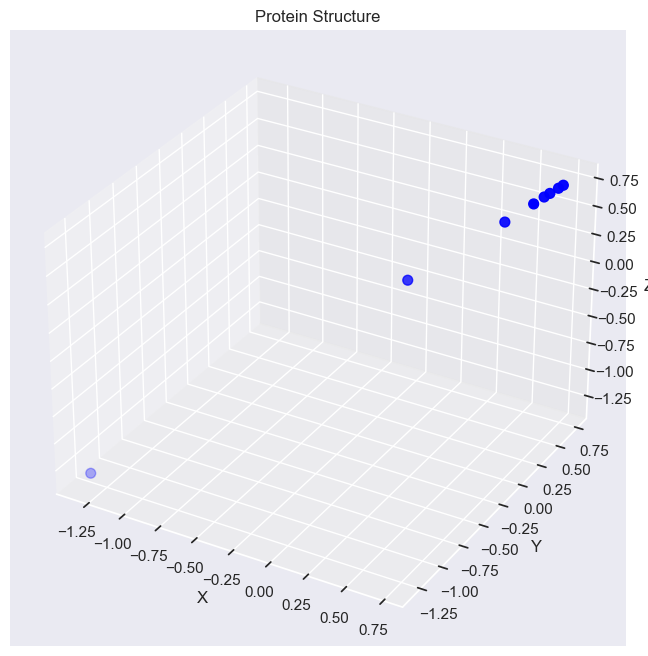


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.319
Std: 0.697
Min: -1.320
Max: 0.725

Avg Neighbor Dist:
Mean: [[0.7051668167114258, 0.6428959369659424, 0.6676503419876099, 0.7259896397590637, 0.05621151626110077, -1.312523365020752, 0.4706065356731415, 0.5879698991775513], [0.7040855288505554, 0.6428930163383484, 0.668383777141571, 0.7253539562225342, 0.05588725954294205, -1.3156853914260864, 0.46717655658721924, 0.6009923815727234]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.319
Std: 0.695
Min: -1.316
Max: 0.725

Neighbor Count:
Mean: 0.319
Std: 0.690
Min: -1.301
Max: 0.726

Small Molecules:
Mean: 0.323
Std: 0.693
Min: -1.306
Max: 0.725

Coordinate Statistics:
Center of mass: [[0.704311728477478, 0.6410907506942749, 0.6693028211593628, 0.7258686423301697, 0.051886193454265594, -1.2928056716918945, 0.45805707573890686, 0.6152290105819702], [0.7050324082374573, 0.6424778699874878, 0.667894721031189,

In [71]:
# Assuming you have a trained model
model = model.to(device)

# Generate and visualize a protein
node_features, edge_index, edge_attr = generate_and_visualize_protein(
    model,
    n_nodes=500,  # Adjust this number as needed
    device=device
)
print_node_statistics(node_features)

In [72]:
print_node_statistics(node_features)


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.319
Std: 0.697
Min: -1.320
Max: 0.725

Avg Neighbor Dist:
Mean: [[0.7051668167114258, 0.6428959369659424, 0.6676503419876099, 0.7259896397590637, 0.05621151626110077, -1.312523365020752, 0.4706065356731415, 0.5879698991775513], [0.7040855288505554, 0.6428930163383484, 0.668383777141571, 0.7253539562225342, 0.05588725954294205, -1.3156853914260864, 0.46717655658721924, 0.6009923815727234]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.319
Std: 0.695
Min: -1.316
Max: 0.725

Neighbor Count:
Mean: 0.319
Std: 0.690
Min: -1.301
Max: 0.726

Small Molecules:
Mean: 0.323
Std: 0.693
Min: -1.306
Max: 0.725

Coordinate Statistics:
Center of mass: [[0.704311728477478, 0.6410907506942749, 0.6693028211593628, 0.7258686423301697, 0.051886193454265594, -1.2928056716918945, 0.45805707573890686, 0.6152290105819702], [0.7050324082374573, 0.6424778699874878, 0.667894721031189,

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:87: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = values.std(dim=0)
/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  print(f"Spatial extent: {coords.std(dim=0).tolist()}")


In [103]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

# Update model parameters
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=128,  # Increased capacity
    latent_channels=16,
    edge_dim=1
).to(device)



# Adjust learning rate schedule
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Update loss weights in the model to focus on underperforming features
model.loss_weights = {
    'mass': 0.1,
    'distance': 0.1,
    'count': 0.05,     # Lara: Updated, old=0.2 ; Increased to improve count prediction
    'small_mol': 0.1,
    'coord': 0.1,
    'edge': 0.2       # Increased to improve edge reconstruction
}

# Train with slightly different parameters
num_epochs = 10
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=100,
    min_beta=0.00001,    # Lower starting point
    max_beta=0.005,      # Slightly lower max
    warmup_epochs=25,    # Longer warmup
    lambda_ortho=0.1     # Keep orthogonal regularization as is
)

/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset prepared:
Number of training graphs: 1308
Number of test graphs: 328
Number of features per node: 8
Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.4494e-09, -1.2249e-08,  1.7266e-09,
         6.3774e-09,  7.4301e-09,  5.9287e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Starting training for 100 epochs...
Training on device: cpu
Number of training batches: 82
Number of validation batches: 21
KL annealing: 1e-05 -> 0.005 over 25 epochs
Orthogonal regularization strength: 0.1


Epoch 1/100 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Batch shapes:
Input x shape: torch.Size([19399, 8])
Edge index shape: torch.Size([2, 77596])
Edge attr shape: torch.Size([77596, 1])
Reconstruction shape: torch.Size([16, 3726, 8])
Edge reconstruction shape: torch.Size([77596, 1])

Detailed loss diagnostics:
Raw recon_loss: 45.0875
Raw KL loss: 0.0031
Ortho loss: 3.0982
Current beta: 0.0000
mu mean: 0.0122, std: 0.0645
logvar mean: 0.0123, std: 0.0608
mass: 2.4104
distance: 2.0216
count: 39.9568
small_mol: 0.0727
coord: 0.4985
edge: 0.1275


Epoch 1/100 [Train]:  12%|█▏        | 10/82 [00:35<03:44,  3.12s/it, loss=16.0763, recon=12.9792, kl=0.0572, ortho=3.0971]


Detailed loss diagnostics:
Raw recon_loss: 3.5735
Raw KL loss: 0.1085
Ortho loss: 3.0979
Current beta: 0.0000
mu mean: 0.0351, std: 0.3625
logvar mean: 0.3256, std: 0.1833
mass: 0.8424
distance: 0.6711
count: 1.4886
small_mol: 0.0372
coord: 0.4244
edge: 0.1097


Epoch 1/100 [Train]:  24%|██▍       | 20/82 [01:03<02:55,  2.83s/it, loss=35.1709, recon=32.0721, kl=0.5135, ortho=3.0987]


Detailed loss diagnostics:
Raw recon_loss: 21.0854
Raw KL loss: 0.3870
Ortho loss: 3.0992
Current beta: 0.0000
mu mean: 0.0508, std: 0.6547
logvar mean: 0.6494, std: 0.2808
mass: 1.0816
distance: 0.8880
count: 16.0768
small_mol: 0.0494
coord: 2.8815
edge: 0.1081


Epoch 1/100 [Train]:  28%|██▊       | 23/82 [01:13<03:07,  3.18s/it, loss=22.9916, recon=19.8932, kl=0.2859, ortho=3.0984]


KeyboardInterrupt: 

In [75]:
import torch

# Assuming `model` is your trained ProteinGraphVAE instance
model_path = 'protein_graph_vae.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to protein_graph_vae.pth


# Latent space

In [76]:
def visualize_latent_space(model, data_loader, device='cuda', method='tsne', perplexity=30):
    """
    Visualize the latent space using t-SNE or PCA.

    Parameters:
    - model: Trained ProteinGraphVAE model.
    - data_loader: PyTorch Geometric DataLoader containing graphs.
    - device: 'cuda' or 'cpu'.
    - method: 'tsne' or 'pca' for dimensionality reduction.
    - perplexity: t-SNE perplexity (only for t-SNE).

    Returns:
    - None (displays the plot).
    """
    model.eval()
    model = model.to(device)
    
    latent_vectors = []
    graph_labels = []  # Collect one label per graph

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            
            # Encode to latent space
            mu, _ = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            
            if mu.size(0) == batch.batch.max().item() + 1:
                # mu is already graph-level
                latent_vectors.append(mu.cpu().numpy())
                graph_labels.extend(range(mu.size(0)))
            else:
                # mu is node-level, pool to graph-level
                pooled_mu = global_mean_pool(mu, batch.batch)  # Shape: [num_graphs, latent_dim]
                latent_vectors.append(pooled_mu.cpu().numpy())
                graph_labels.extend(batch.batch.unique().cpu().numpy())  # Graph-level labels
    
    # Concatenate results
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    graph_labels = np.array(graph_labels[:len(latent_vectors)])  # Ensure labels match latent vectors

    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")
    
    reduced_latent = reducer.fit_transform(latent_vectors)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        reduced_latent[:, 0],
        reduced_latent[:, 1],
        c=graph_labels[:reduced_latent.shape[0]],  # Use graph-level labels
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Graph Labels')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()



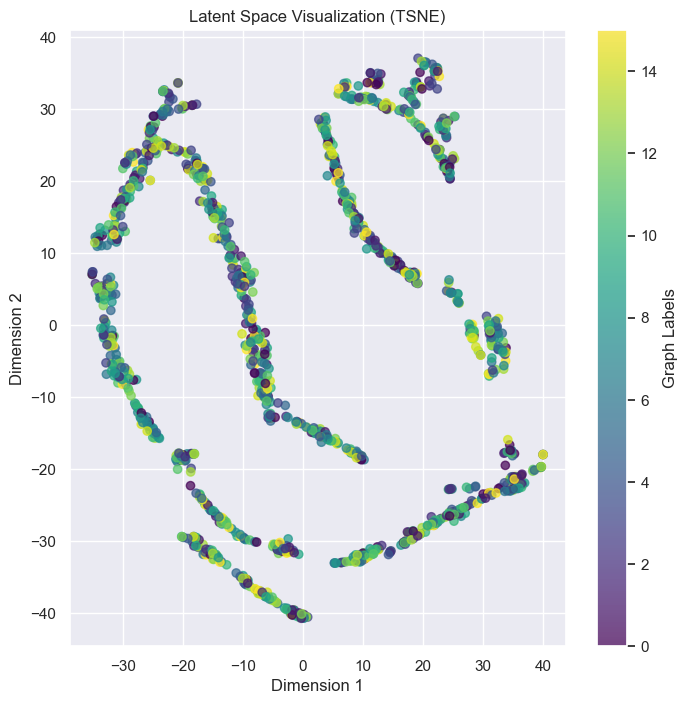

In [77]:
visualize_latent_space(model, train_loader, device=device, method='tsne', perplexity=30)

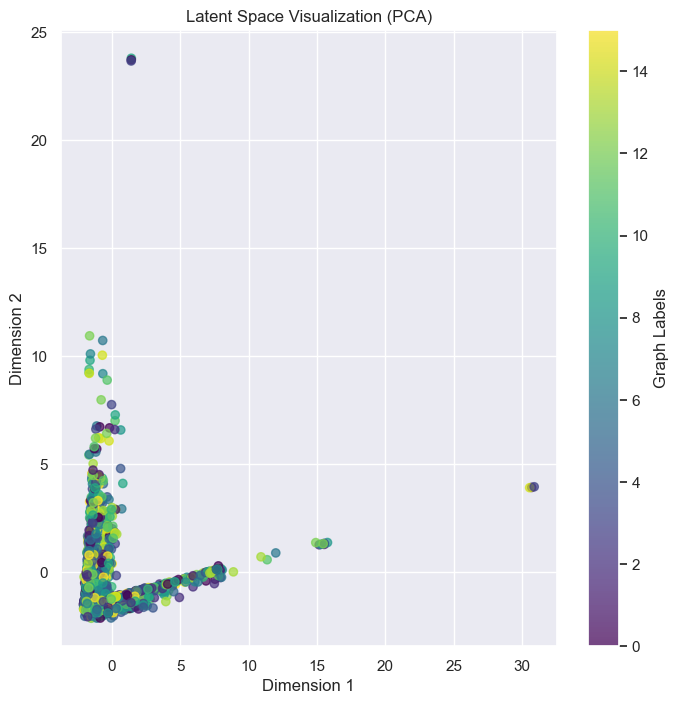

In [78]:
visualize_latent_space(model, train_loader, device=device, method='pca')

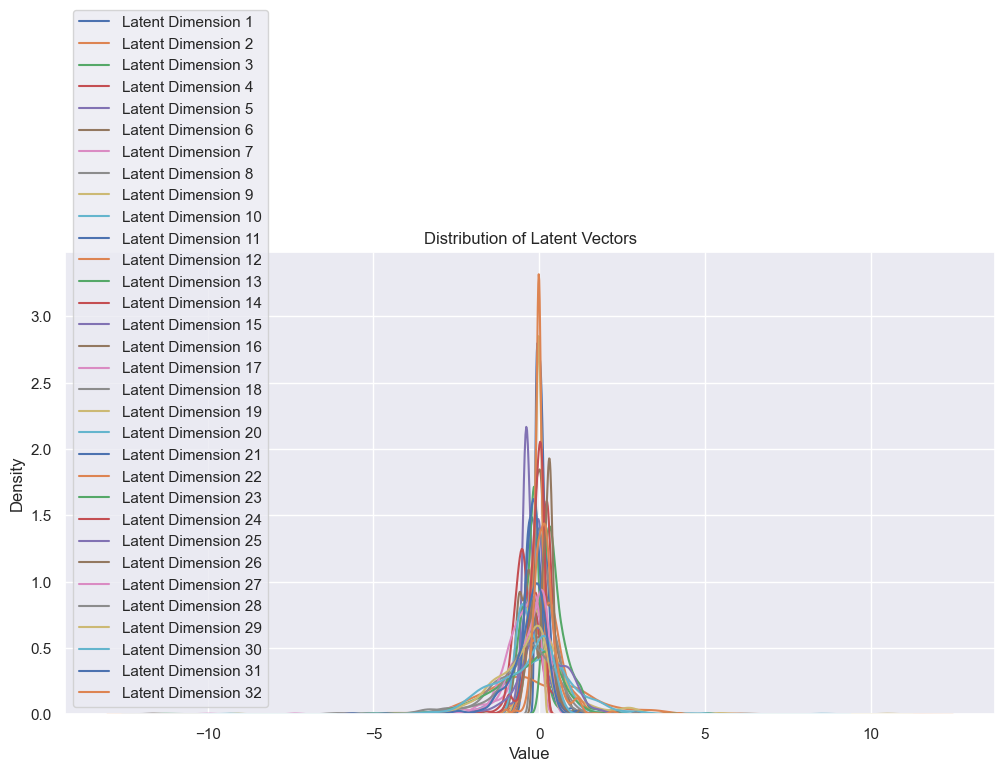

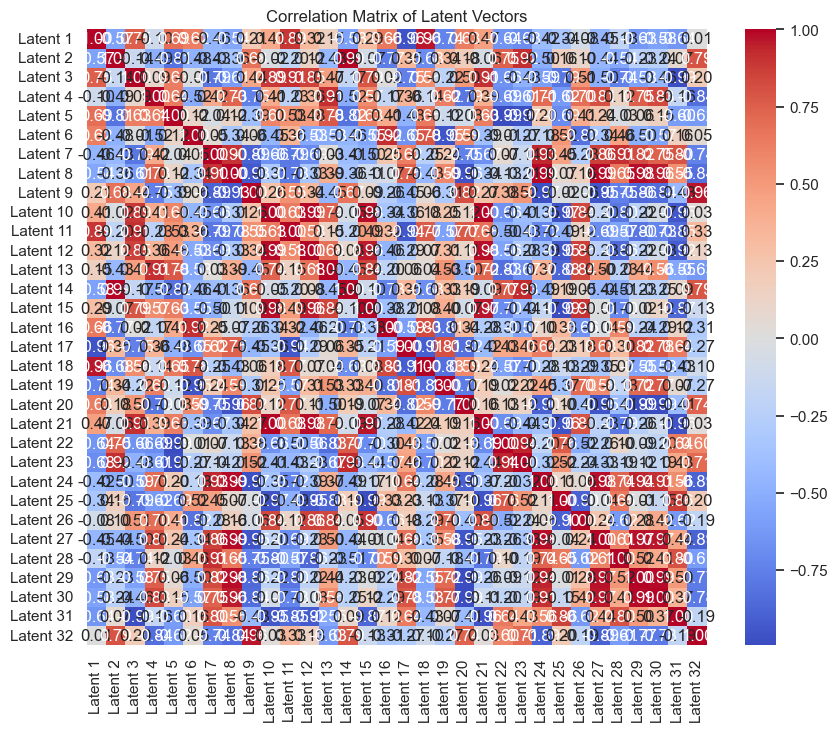

In [79]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_latent_distribution_and_correlation(model, data_loader, device):
    """
    Plot the distribution of latent vectors and the correlation matrix.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
    """
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Plot the distribution of latent vectors
    plt.figure(figsize=(12, 6))
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(latent_vectors[:, i], label=f'Latent Dimension {i+1}')
    plt.title('Distribution of Latent Vectors')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Compute and plot the correlation matrix
    correlation_matrix = np.corrcoef(latent_vectors, rowvar=False)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                xticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])],
                yticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])])
    plt.title('Correlation Matrix of Latent Vectors')
    plt.show()

# Example usage
plot_latent_distribution_and_correlation(model, train_loader, device)

In [80]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance

def analyze_latent_space(model, data_loader, device, save_path=None):
    """
    Analyze and visualize the latent space distributions and correlations
    
    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        save_path: Optional path to save visualizations
    """
    model.eval()
    latent_vectors = []

    # Collect latent vectors
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            latent_vectors.append(mu.cpu().numpy())

    # Concatenate all latent vectors
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))

    # 1. Distribution plots for each latent dimension
    ax1 = plt.subplot(231)
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(data=latent_vectors[:, i], ax=ax1, label=f'Dim {i}')
    ax1.set_title('Latent Dimension Distributions')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Correlation matrix
    ax2 = plt.subplot(232)
    corr_matrix = np.corrcoef(latent_vectors.T)
    sns.heatmap(corr_matrix,
                ax=ax2,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax2.set_title('Latent Dimension Correlations')

    # 3. PCA visualization
    ax3 = plt.subplot(233)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    scatter = ax3.scatter(pca_result[:, 0],
                          pca_result[:, 1],
                          alpha=0.5,
                          c=np.sum(latent_vectors**2, axis=1),  # Color by L2 norm
                          cmap='viridis')
    plt.colorbar(scatter, ax=ax3, label='L2 Norm')
    ax3.set_title(f'PCA Projection\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}')

    # 4. Box plot of latent dimensions
    ax4 = plt.subplot(234)
    ax4.boxplot(latent_vectors)
    ax4.set_title('Latent Dimension Ranges')
    ax4.set_xlabel('Dimension')
    ax4.set_ylabel('Value')

    # 5. Dimension-wise statistics
    ax5 = plt.subplot(235)
    stats = pd.DataFrame({
        'Mean': np.mean(latent_vectors, axis=0),
        'Std': np.std(latent_vectors, axis=0),
        'Median': np.median(latent_vectors, axis=0),
        'IQR': np.percentile(latent_vectors, 75, axis=0) - np.percentile(latent_vectors, 25, axis=0)
    })
    stats.index = [f'Dim {i}' for i in range(latent_vectors.shape[1])]
    sns.heatmap(stats,
                ax=ax5,
                cmap='viridis',
                annot=True,
                fmt='.2f')
    ax5.set_title('Dimension-wise Statistics')

    # 6. Wasserstein distance matrix between dimensions
    ax6 = plt.subplot(236)
    n_dims = latent_vectors.shape[1]
    wasserstein_mat = np.zeros((n_dims, n_dims))
    for i in range(n_dims):
        for j in range(n_dims):
            wasserstein_mat[i, j] = wasserstein_distance(
                latent_vectors[:, i],
                latent_vectors[:, j]
            )
    sns.heatmap(wasserstein_mat,
                ax=ax6,
                cmap='viridis',
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax6.set_title('Wasserstein Distances\nbetween Dimensions')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Calculate additional metrics
    metrics = {
        'mean_correlation': np.mean(np.abs(corr_matrix - np.eye(n_dims))),
        'max_correlation': np.max(np.abs(corr_matrix - np.eye(n_dims))),
        'mean_wasserstein': np.mean(wasserstein_mat),
        'dimension_entropy': -np.sum(np.mean(latent_vectors, axis=0) * np.log(np.abs(np.mean(latent_vectors, axis=0)) + 1e-10)),
        'pca_explained_variance': pca.explained_variance_ratio_.sum()
    }

    return fig, metrics

def visualize_latent_traversal(model, data_loader, device, dim_idx=0, n_steps=10):
    """
    Visualize how changing a single latent dimension affects the reconstruction
    
    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        dim_idx: Index of dimension to traverse
        n_steps: Number of steps in traversal
    """
    model.eval()

    # Get a sample batch
    batch = next(iter(data_loader)).to(device)

    # Get latent representation
    with torch.no_grad():
        mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        z = model.reparameterize(mu, logvar)

    # Create traversal values
    traversal_range = np.linspace(-3, 3, n_steps)
    reconstructions = []

    # Generate reconstructions
    with torch.no_grad():
        for value in traversal_range:
            z_new = z.clone()
            z_new[:, dim_idx] = value
            recon, edge_recon = model.decode(z_new, batch.x.size(0), batch.edge_index)
            reconstructions.append(recon.cpu().numpy())

    return np.array(reconstructions), traversal_range

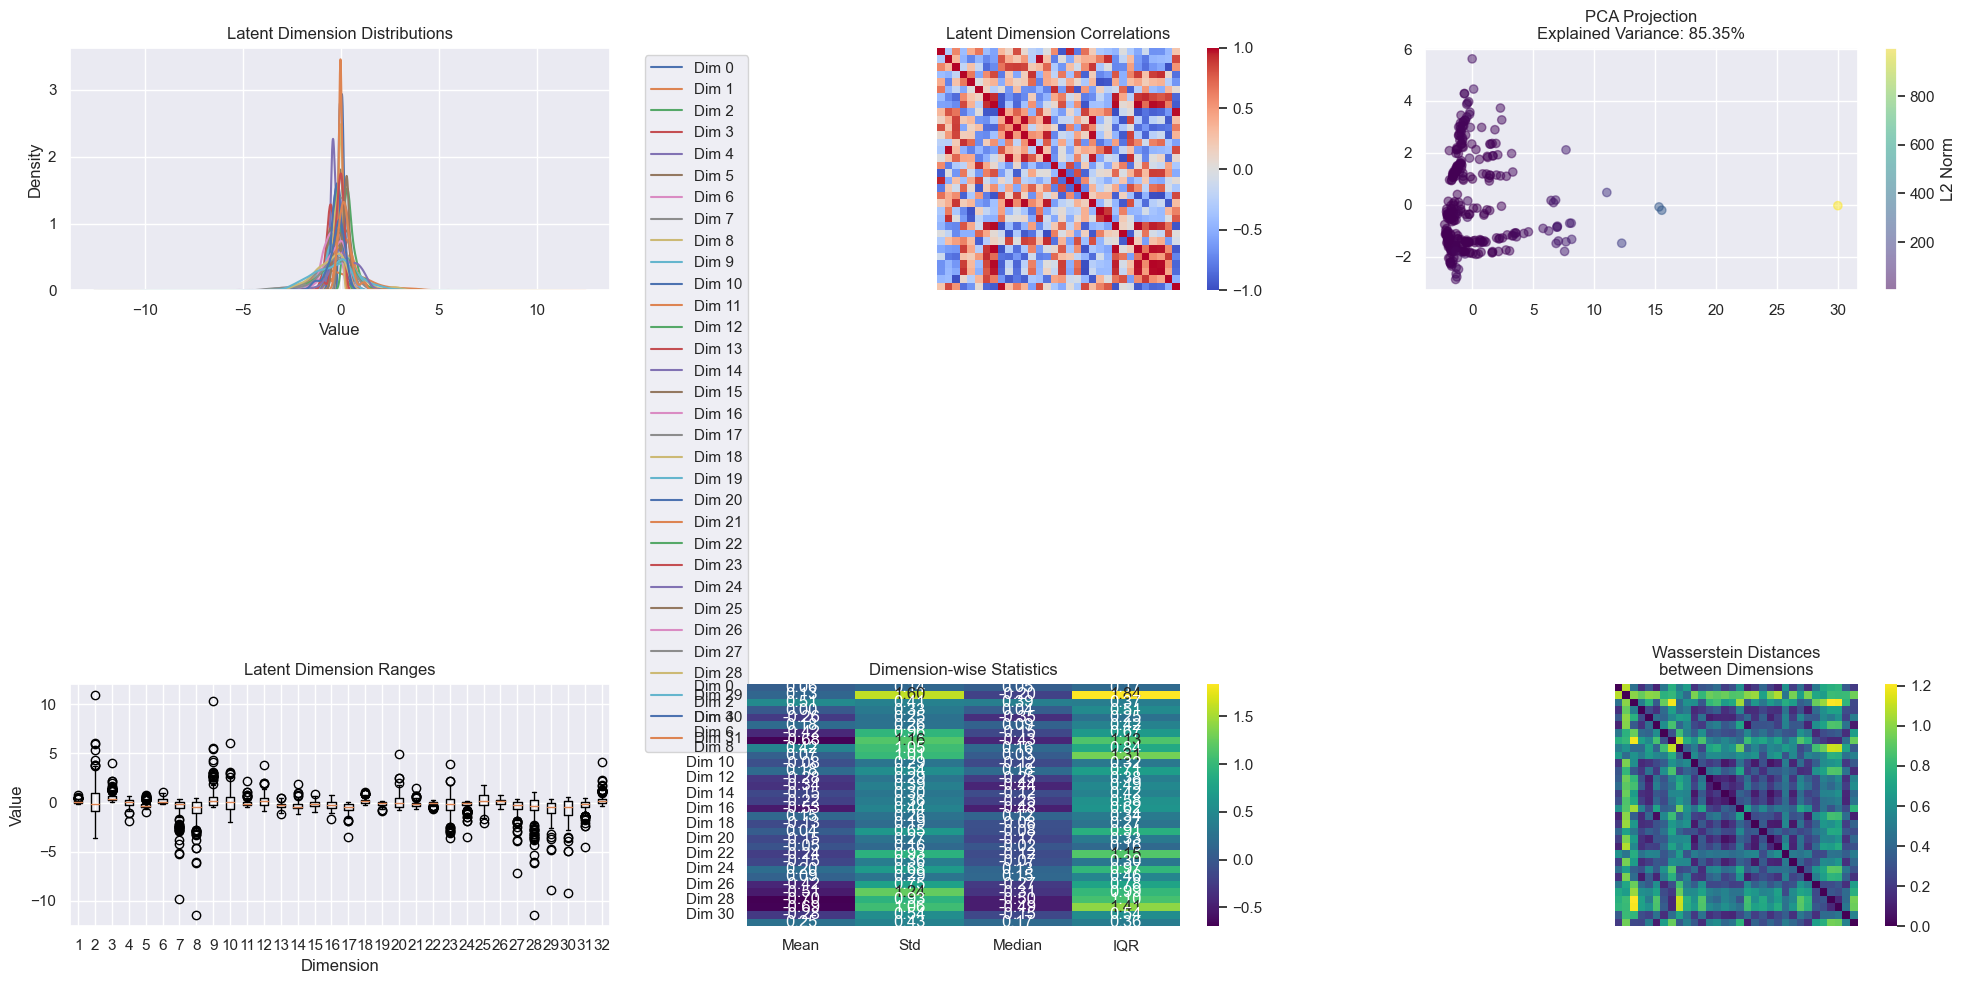

mean_correlation: 0.4954
max_correlation: 0.9980
mean_wasserstein: 0.4472
dimension_entropy: -2.5192
pca_explained_variance: 0.8535


In [81]:
# After training your model
fig, metrics = analyze_latent_space(model, test_loader, device)
plt.show()

# Print latent space metrics
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Visualize how changing dimension 0 affects reconstruction
reconstructions, traversal_values = visualize_latent_traversal(model, test_loader, device, dim_idx=0)

# Generator

In [82]:
import torch
from torch_geometric.data import Data
import numpy as np

def generate_edges_from_coordinates(coords, threshold=5.0):
    """
    Generate edges based on distances between node coordinates.
    """
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr



In [83]:
def generate_protein_graphs(model, graphs, num_samples=5, nodes_per_graph=200, temperature=1.5):
    """
    Generate new protein graphs with diverse node features.
    """
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Step 1: Calculate normalization parameters
    feature_means, feature_stds = norm_params
    print(f"Feature means: {feature_means}")
    print(f"Feature stds: {feature_stds}")

    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Step 2: Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature
        print("Sampled latent vectors (z):", z)

        # Step 3: Generate graphs
        for i in range(num_samples):
            # Decode latent vector into node features
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)
            decoded_features, _ = model.decode(z_expanded, num_nodes=nodes_per_graph, edge_index=torch.empty(2, 0, dtype=torch.long, device=device)) # Placeholder edge_index
            print("Decoded features (before unnormalization):", decoded_features)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Extract coordinates and generate edges
            coords = decoded_features[:, -3:]  # Last three columns are X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)
            print("Edge index:", edge_index)
            print("Edge attributes:", edge_attr)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


In [84]:
# Extract only the graphs from the tuples
graph_data = [g[1] for g in graphs]

# Use the extracted graphs to generate proteins
generated_proteins = generate_protein_graphs(
    model=model,
    graphs=graph_data,  # Pass only the graphs
    num_samples=5,
    nodes_per_graph=200,
    temperature=1.5
)

Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.6606e-09,  1.3305e-08, -1.2001e-08,
         6.9406e-09,  7.5005e-09,  5.9287e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Sampled latent vectors (z): tensor([[ 0.3398, -0.7944,  0.4709,  0.4872,  1.7135,  1.5668, -0.5694, -0.7921,
         -1.4671,  1.3816, -1.0118, -0.2306, -0.8609,  0.5996, -1.1732,  0.7359,
         -2.6810, -1.8402, -1.1602, -1.1143,  1.5624,  1.5851, -0.8021, -1.4287,
          1.9394, -2.1633, -2.0087,  2.7459,  1.7573,  0.9614,  0.9390,  0.8250],
        [-0.3666,  3.4403, -1.2933, -0.9068, -1.0760,  1.8937,  0.3490, -0.2912,
         -1.5676, -1.0091,  0.1248, -2.1768,  1.2331, -2.6619,  0.0628,  2.3569,
          1.0291, -1.3739, -0.4153,  1.1019,  1.4245, -0.7797,  0.8290,  0.1462,
         -3.3847,  0.9127, -2.2771,  1.6768,  1.1465,  1.5842, -0.3482, -0.1955],
        [-2.4123,  2.1769, -2.3182, -0.3070, -2.1457, -4.0458, -3.1652,  2.2251,
          1.2526,  1.0813,  0.9036,  0.2328,  0.49

In [85]:
# Analyze the generated graphs
for i, protein in enumerate(generated_proteins):
    print(f"Protein {i+1}:")
    print(f"  Number of nodes: {protein.x.size(0)}")
    print(f"  Number of edges: {protein.edge_index.size(1)}")
    print(f"  Feature mean: {protein.x.mean(dim=0)}")
    print(f"  Feature std: {protein.x.std(dim=0)}")


Protein 1:
  Number of nodes: 200
  Number of edges: 39800
  Feature mean: tensor([[-1.7203e-09,  1.9603e-09,  5.7905e-09,  ..., -1.5714e-01,
         -2.3612e-01, -2.5232e-01],
        [-1.7222e-09,  1.9519e-09,  5.7831e-09,  ..., -1.5786e-01,
         -2.3657e-01, -2.5265e-01],
        [-1.7247e-09,  1.9445e-09,  5.7763e-09,  ..., -1.5773e-01,
         -2.3643e-01, -2.5256e-01],
        ...,
        [-1.7025e-09,  2.0265e-09,  5.8494e-09,  ..., -1.5737e-01,
         -2.3580e-01, -2.5188e-01],
        [-1.7286e-09,  1.9292e-09,  5.7628e-09,  ..., -1.5750e-01,
         -2.3636e-01, -2.5263e-01],
        [-1.7202e-09,  1.9611e-09,  5.7912e-09,  ..., -1.5708e-01,
         -2.3576e-01, -2.5194e-01]])
  Feature std: tensor([[1.0548e-10, 3.9954e-10, 3.5535e-10,  ..., 7.8985e-03, 6.8404e-03,
         6.6408e-03],
        [1.0865e-10, 4.1071e-10, 3.6521e-10,  ..., 7.5842e-03, 6.3945e-03,
         6.2265e-03],
        [1.0192e-10, 3.8682e-10, 3.4377e-10,  ..., 7.1801e-03, 6.0451e-03,
         

(test latest version)

In [86]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.data import Data

def generate_protein_graphs(model, norm_params, num_samples=1, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add node-specific variations
        z = z.unsqueeze(1).repeat(1, nodes_per_graph, 1)
        node_noise = torch.randn_like(z) * 0.1
        z = z + node_noise

        # Reshape for decoder
        z = z.view(-1, model.latent_channels)

        # Create initial dummy edge_index for decoding
        edge_index = torch.arange(nodes_per_graph * num_samples, device=device)
        edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

        # Decode the latent vectors
        decoded, _ = model.decode(z, nodes_per_graph, edge_index)

        # Unnormalize the features
        decoded = decoded * feature_stds.to(device) + feature_means.to(device)


        # Process each generated graph
        for i in range(num_samples):
            # Extract features for this graph
            start_idx = i * nodes_per_graph
            end_idx = (i + 1) * nodes_per_graph
            features = decoded[i]  # Get features for this graph

            # Generate edges based on coordinates
            coords = features[..., -3:]
            edge_index = []
            edge_attr = []

            for j in range(len(coords)):
                for k in range(j + 1, len(coords)):
                    dist = torch.norm(coords[j] - coords[k])
                    if dist < 5.0:  # Threshold for edge creation
                        edge_index.extend([[j, k], [k, j]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                # Fallback: connect nearest neighbors if no edges were created
                dists = torch.cdist(coords, coords)
                k = 3  # Connect to k nearest neighbors
                _, indices = torch.topk(-dists, k + 1)  # Negative for closest

                edge_index = []
                edge_attr = []
                for j in range(len(coords)):
                    for idx in indices[j][1:]:  # Skip self
                        edge_index.extend([[j, idx.item()], [idx.item(), j]])
                        dist = dists[j, idx].item()
                        edge_attr.extend([dist, dist])

                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)

            # Create graph
            graph = Data(
                x=features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def interpolate_proteins(model, protein1, protein2, num_steps=10, device='cuda'):
    """
    Generate interpolated proteins between two existing proteins
    """
    model.eval()
    model = model.to(device)

    # Convert proteins to batches
    batch1 = torch.zeros(protein1.x.size(0), dtype=torch.long)
    batch2 = torch.zeros(protein2.x.size(0), dtype=torch.long)

    # Get latent representations
    with torch.no_grad():
        protein1 = protein1.to(device)
        protein2 = protein2.to(device)

        mu1, _ = model.encode(protein1.x, protein1.edge_index, protein1.edge_attr, batch1)
        mu2, _ = model.encode(protein2.x, protein2.edge_index, protein2.edge_attr, batch2)

        # Interpolate in latent space
        interpolated_graphs = []
        alphas = np.linspace(0, 1, num_steps)

        max_nodes = max(protein1.x.size(0), protein2.x.size(0))

        for alpha in alphas:
            # Interpolate latent vectors
            z = (1 - alpha) * mu1 + alpha * mu2

            # Create initial dummy edge_index for decoding
            edge_index = torch.arange(max_nodes, device=device)
            edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

            # Decode
            decoded, _ = model.decode(z.unsqueeze(0), max_nodes, edge_index)
            decoded = decoded[0]

            # Process decoded features
            coords = decoded[:, -3:]

            # Generate edges based on distances
            edge_index = []
            edge_attr = []

            for i in range(len(coords)):
                for j in range(i + 1, len(coords)):
                    dist = torch.norm(coords[i] - coords[j])
                    if dist < 5.0:
                        edge_index.extend([[i, j], [j, i]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=decoded,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            interpolated_graphs.append(graph)

    return interpolated_graphs
def visualize_protein_graph(graph, title="Generated Protein Structure"):
    """Improved visualization of protein graph"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates
    coords = graph.x[:, -3:].cpu().numpy()
    masses = graph.x[:, 0].cpu().numpy()  # Use mass for point size
    small_mols = graph.x[:, 4].cpu().numpy()  # Use for coloring

    # Scale masses for visualization
    sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100

    # Plot nodes with size based on mass and color based on small molecules
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=small_mols, cmap='coolwarm',
                         s=sizes, alpha=0.6)

    # Plot edges
    edges = graph.edge_index.cpu().numpy()
    for i in range(0, edges.shape[1], 2):
        start = coords[edges[0, i]]
        end = coords[edges[1, i]]
        ax.plot([start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]], 'gray', alpha=0.2)

    plt.colorbar(scatter, label='Small Molecules')
    ax.set_title(title)

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    plt.show()


# Example usage:
def generate_and_visualize_proteins(model, device='cuda'):
    """
    Generate and visualize some example proteins
    """
    # Generate new proteins
    print("Generating new proteins...")
    generated = generate_protein_graphs(model, num_samples=3, nodes_per_graph=100, device=device)

    # Visualize each generated protein
    for i, graph in enumerate(generated):
        visualize_protein_graph(graph, f"Generated Protein {i+1}")

    return generated

def interpolate_and_visualize(model, protein1, protein2, device='cuda'):
    """
    Interpolate between two proteins and visualize the results
    """
    print("Generating interpolated proteins...")
    interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)

    # Visualize interpolation
    for i, graph in enumerate(interpolated):
        visualize_protein_graph(graph, f"Interpolation Step {i+1}")

    return interpolated

def print_graph_info(graph, title="Graph Info", num_samples=5):
    print(f"\n{title}")
    print(f"Node features shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")

    # Print feature statistics
    print("\nFeature statistics:")
    print(f"Mass range: {graph.x[:, 0].min().item():.2f} to {graph.x[:, 0].max().item():.2f}")
    print(f"Avg Neighbor Dist range: {graph.x[:, 1].min().item():.2f} to {graph.x[:, 1].max().item():.2f}")
    print(f"Max Neighbor Dist range: {graph.x[:, 2].min().item():.2f} to {graph.x[:, 2].max().item():.2f}")
    print(f"Neighbor Count range: {graph.x[:, 3].min().item():.2f} to {graph.x[:, 3].max().item():.2f}")
    print(f"Small Molecules ratio: {graph.x[:, 4].mean().item():.2f}")

    print("\nSample nodes:")
    for i in range(min(num_samples, len(graph.x))):
        features = graph.x[i]
        print(f"\nNode {i}:")
        print(f"  Mass: {features[0].item():.2f}")
        print(f"  Avg/Max Neighbor Dist: {features[1].item():.2f}/{features[2].item():.2f}")
        print(f"  Neighbor Count: {features[3].item():.0f}")
        print(f"  Small Molecules: {features[4].item():.0f}")
        print(f"  Coordinates: ({features[5].item():.2f}, {features[6].item():.2f}, {features[7].item():.2f})")


In [87]:
generated_proteins = generate_protein_graphs(
    model=model,               # The trained model
    norm_params=norm_params,   # Use normalization parameters from preprocessing
    num_samples=3,             # Number of proteins to generate
    nodes_per_graph=100,       # Number of nodes per generated graph
    temperature=1.0            # Sampling diversity
)

In [101]:
def map_mass_to_color(mass_value):
    """Map a mass value to the closest amino acid color."""
    # Scale the negative values around -9.76 to the amino acid mass range
    scaled_mass = (abs(mass_value) + 1) * 20  # This should map to 75-255 range

    print(f"Original mass: {mass_value}, Scaled mass: {scaled_mass}")
    closest_aa = min(AMINO_ACID_DATA,
                     key=lambda x: abs(x[0] - scaled_mass))
    return closest_aa[2]

def visualize_generated_protein_graph(data, title="Generated Protein Graph"):
    # First create the initial graph with all attributes
    original_G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Store node attributes before filtering
    node_attrs = {node: attrs['x'] for node, attrs in original_G.nodes(data=True)}

    # Create filtered graph while preserving node attributes
    edge_threshold = 0.003
    G = nx.Graph((u, v, d) for u, v, d in original_G.edges(data=True)
                 if float(d['edge_attr'][0]) > edge_threshold)

    # Add back node attributes
    nx.set_node_attributes(G, {node: {'x': attrs} for node, attrs in node_attrs.items()})

    pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)

    node_colors = [map_mass_to_color(node_attrs[node][4]) for node in G.nodes()]
    node_sizes = [max(300, abs(float(node_attrs[node][5]) * 2000)) for node in G.nodes()]

    edge_weights = [
        max(0.1, min(1.0, float(edge[2]['edge_attr'][0]) * 50))
        for edge in G.edges(data=True)
    ]

    plt.figure(figsize=(12, 12))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',
        width=edge_weights,
        alpha=0.7,
        with_labels=False
    )

    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=name, markersize=10)
                       for mass, name, color in AMINO_ACID_DATA]
    plt.legend(handles=legend_elements, loc='center left',
               bbox_to_anchor=(1, 0.5), title="Amino Acids")

    plt.title(title)
    plt.tight_layout()
    plt.show()

Original mass: -9.760345458984375, Scaled mass: 215.2069091796875
Original mass: -9.728754043579102, Scaled mass: 214.57508087158203
Original mass: -9.573446273803711, Scaled mass: 211.46892547607422
Original mass: -9.603184700012207, Scaled mass: 212.06369400024414
Original mass: -9.53791618347168, Scaled mass: 210.7583236694336
Original mass: -10.025009155273438, Scaled mass: 220.50018310546875
Original mass: -9.456985473632812, Scaled mass: 209.13970947265625
Original mass: -9.668157577514648, Scaled mass: 213.36315155029297
Original mass: -9.661712646484375, Scaled mass: 213.2342529296875
Original mass: -9.764103889465332, Scaled mass: 215.28207778930664
Original mass: -9.645195960998535, Scaled mass: 212.9039192199707
Original mass: -9.522172927856445, Scaled mass: 210.4434585571289
Original mass: -9.414767265319824, Scaled mass: 208.29534530639648
Original mass: -9.978666305541992, Scaled mass: 219.57332611083984
Original mass: -9.79273796081543, Scaled mass: 215.8547592163086
Or

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/40893172.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


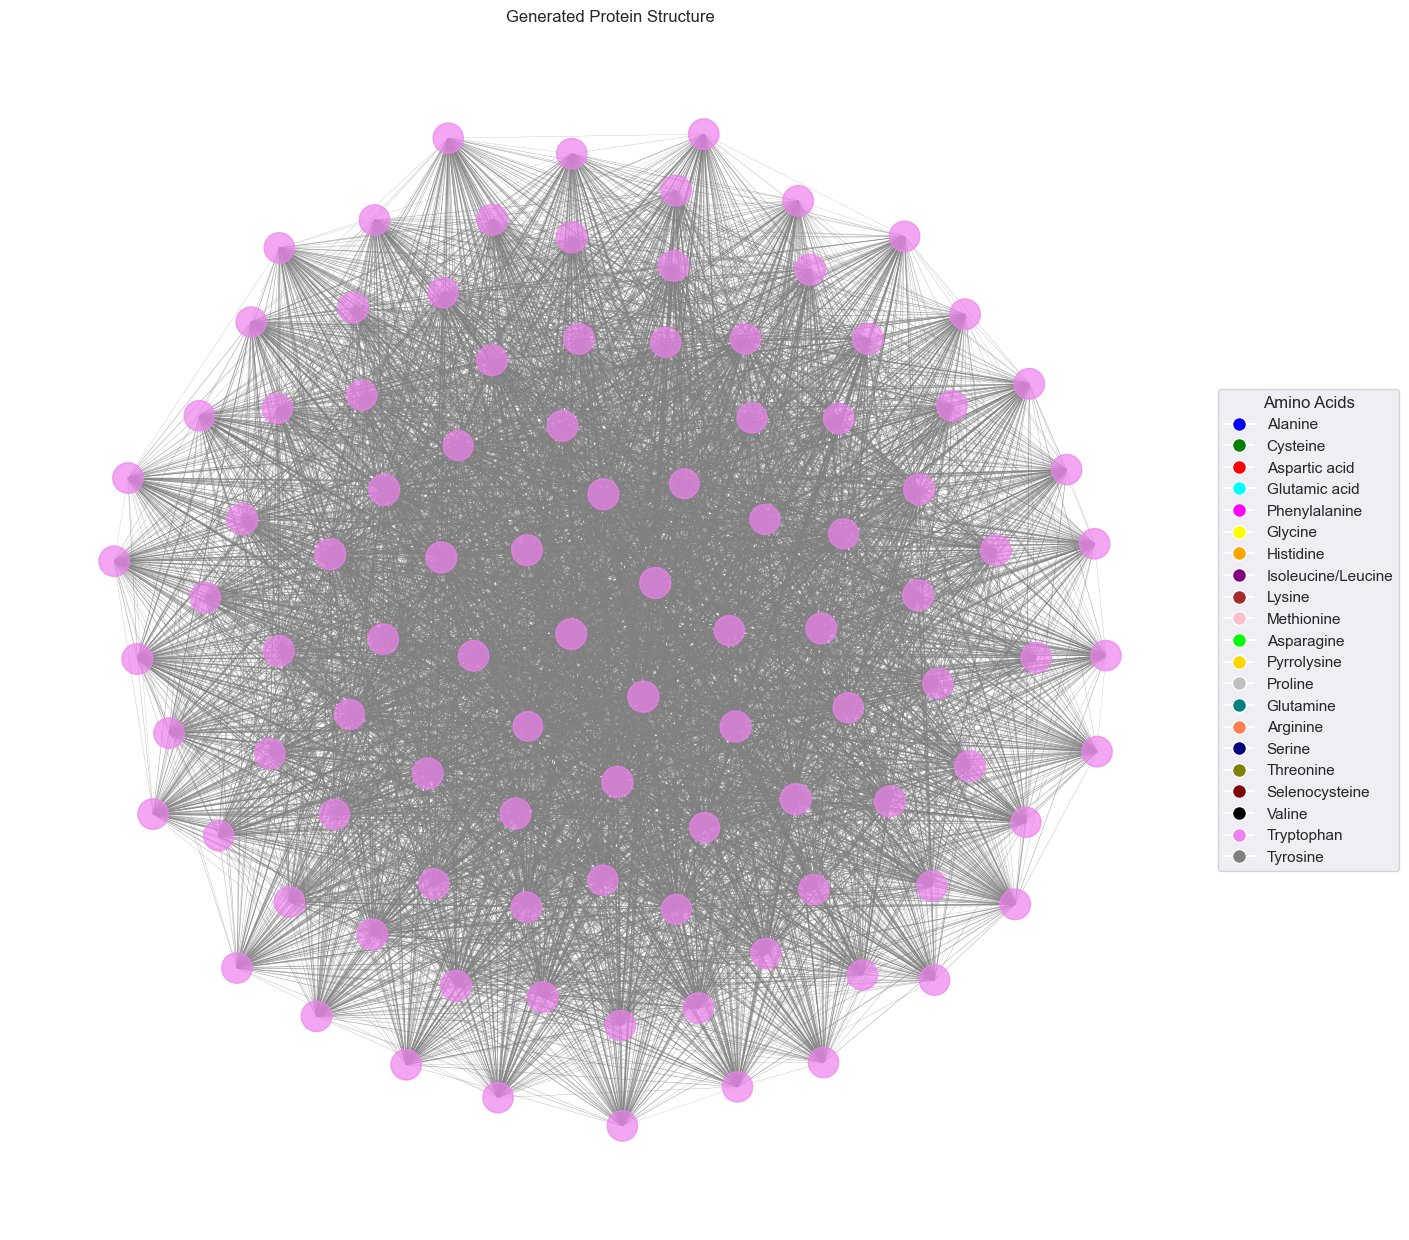

In [102]:
generated_protein = generated_proteins[0]  # Assume you have generated graphs
visualize_generated_protein_graph(generated_protein, title="Generated Protein Structure")


In [89]:
generated_proteins[0]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

In [90]:
generated_proteins[1]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

New generator: 

In [91]:
def generate_protein_graphs(model, norm_params, num_samples=3, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add small random noise for variability
        z = z + torch.randn_like(z) * 0.1

        for i in range(num_samples):
            # Expand latent vector for all nodes
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)

            # Decode latent vectors into node features
            decoded_features, _ = model.decode(z_expanded, nodes_per_graph, edge_index=None)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Generate edges based on spatial coordinates (decoded)
            coords = decoded_features[:, -3:]  # Extract X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def generate_edges_from_coordinates(coords, threshold=5.0):
    """Generate edges based on distances between coordinates"""
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return edge_index, edge_attr


In [103]:
generated_proteins = generate_protein_graphs(
    model=model,
    norm_params=(, feature_stds),
    num_samples=3,
    nodes_per_graph=100,
    temperature=1.0
)

# Check if graphs are diverse
for i, graph in enumerate(generated_proteins):
    print(f"Graph {i}: Node Features Mean: {graph.x.mean(dim=0)}, Std: {graph.x.std(dim=0)}")


NameError: name 'feature_means' is not defined